<h1>Прогнозирование заказов такси<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта-и-данных" data-toc-modified-id="Описание-проекта-и-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта и данных</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

##  Описание проекта и данных

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [3]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df = df.sort_index()

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [8]:
df['num_orders'] = df['num_orders'].astype('int16')

In [9]:
df = df.resample('1H').sum()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int16
dtypes: int16(1)
memory usage: 43.1 KB


In [11]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [12]:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">

**Вывод по разделу:**

Данные загружены, даты выставлены в качестве индексов. Изменен тип данных для экономии памяти. Данные ресэмплированы по одному часу и просуммированы.

## Анализ

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">

Разложим временной ряд на три составляющие: тренд, сезонность и остаток.

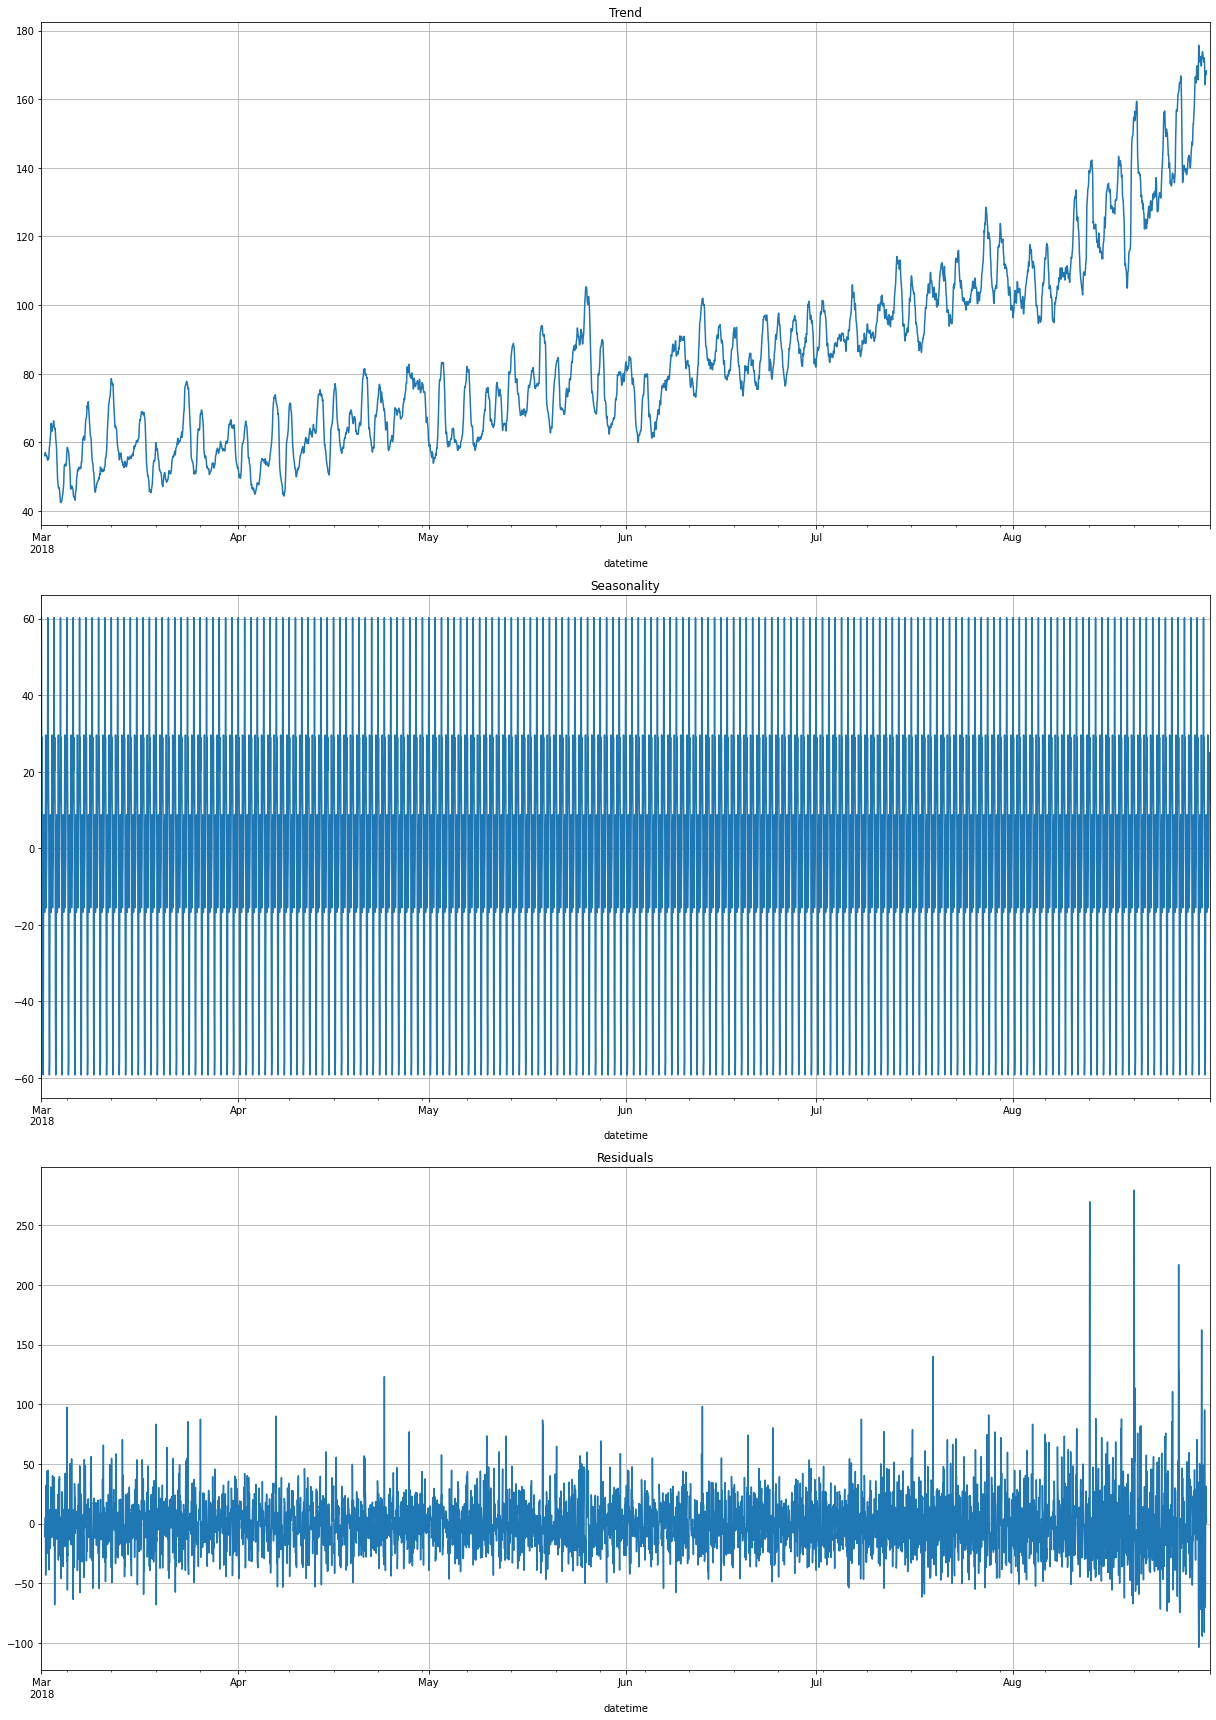

In [13]:
# декомпозиция всего ряда
decomposed = seasonal_decompose(df)
plt.figure(figsize=(17, 24))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), grid=True)
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), grid=True)
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), grid=True) 
plt.title('Residuals')
plt.tight_layout()

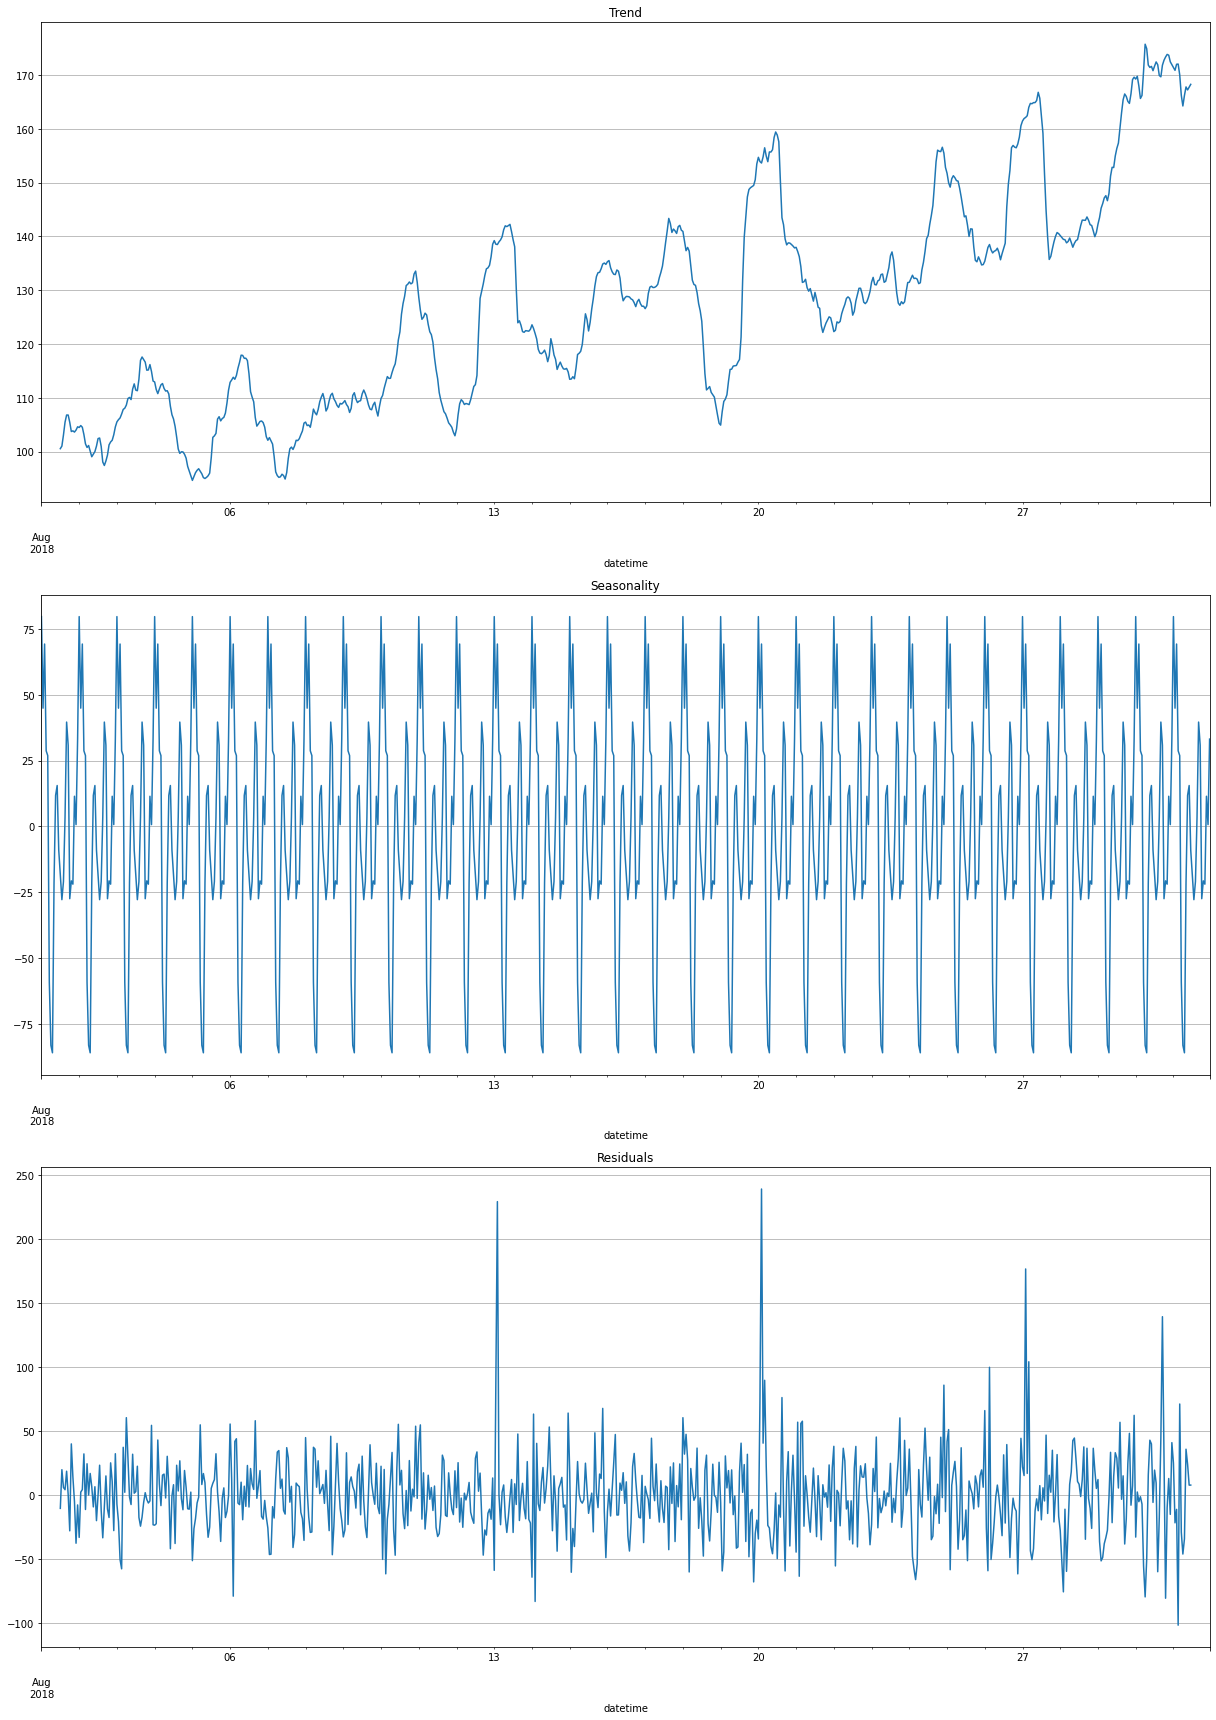

In [14]:
# декомпозиция последнего месяца данных
decomposed = seasonal_decompose(df['2018-08':'2018-08'])
plt.figure(figsize=(17, 24))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), grid=True)
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), grid=True)
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), grid=True) 
plt.title('Residuals')
plt.tight_layout()

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">

**Вывод по разделу:**
    
* Тренд показывает постепенный рост количества заказок. Примерно каждые 3 дня происходит падение. Линия тренда имеет скорее квадратичную зависимость, нежели линейную.
* Сезонная часть выглядит стационарной. Ночью количество заказов минимально, с утра и до вечера идет рост.
* Остаточная часть преимуществнно лежит в одном диапазоне, но встречаются выбросы, которые, возможно, случаются в период праздников или непогоды.

## Обучение

In [15]:
# оценка модели по предыдущим значениям ряда
train, test = train_test_split(df, shuffle=False, test_size=0.1)
print("Среднее количество заказов в час:", test['num_orders'].mean())
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse_m =  mean_squared_error(test['num_orders'], pred_previous) ** 0.5
print("RMSE_previous:", rmse_m)

# оценка модели по медианному значению ряда
pred_median = np.ones(test.shape) * train['num_orders'].median()
rmse_median = mean_squared_error(test['num_orders'], pred_median) ** 0.5
print("RMSE_median:", rmse_median)

Среднее количество заказов в час: 139.55656108597285
RMSE_previous: 58.856486242815066
RMSE_median: 87.15277582981295


In [16]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['year'] = data_new.index.year
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)
    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new

In [18]:
def make_tt(df):
    train, test = train_test_split(df, shuffle=False, test_size=0.1)
    train = train.dropna()
    train.loc[:,(train.columns != 'rolling_mean')] = train.loc[:,(train.columns != 'rolling_mean')].astype('int16')
    test.loc[:,(test.columns != 'rolling_mean')] = test.loc[:,(test.columns != 'rolling_mean')].astype('int16')
    feature_train = train.drop('num_orders', axis = 1)
    target_train = train['num_orders']
    feature_test = test.drop('num_orders', axis = 1)
    target_test = test['num_orders']
    return feature_train, target_train, feature_test, target_test

In [19]:
df_mf = make_features(df, 28, 7)

In [20]:
df_mf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int16  
 1   year          4416 non-null   int64  
 2   month         4416 non-null   int64  
 3   day           4416 non-null   int64  
 4   dayofweek     4416 non-null   int64  
 5   lag_1         4415 non-null   float64
 6   lag_2         4414 non-null   float64
 7   lag_3         4413 non-null   float64
 8   lag_4         4412 non-null   float64
 9   lag_5         4411 non-null   float64
 10  lag_6         4410 non-null   float64
 11  lag_7         4409 non-null   float64
 12  lag_8         4408 non-null   float64
 13  lag_9         4407 non-null   float64
 14  lag_10        4406 non-null   float64
 15  lag_11        4405 non-null   float64
 16  lag_12        4404 non-null   float64
 17  lag_13        4403 non-null

In [21]:
feature_train, target_train, feature_test, target_test = make_tt(df_mf)

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [22]:
warnings.filterwarnings('ignore')

In [23]:
feature_train.shape, target_train.shape

((3946, 33), (3946,))

In [24]:
feature_test.shape, target_test.shape

((442, 33), (442,))

In [25]:
train.shape

(3974, 1)

### LinearRegression

In [26]:
best_num_lag = 0
best_rolling_size = 0
best_score_lr = 48
tscv = TimeSeriesSplit(n_splits=3)
for num_lag in range(5,61, 5):
    for roll_size in range(5, 61, 5):
        df_mf = make_features(df, num_lag, roll_size)
        feature_train, target_train, feature_test, target_test = make_tt(df_mf)
        model_lr = LinearRegression()
        cv_results = cross_val_score(model_lr, feature_train, target_train, 
                                     cv=tscv, scoring='neg_root_mean_squared_error').mean()
        if abs(cv_results) < best_score_lr:
            best_score_lr = abs(cv_results)
            best_num_lag = num_lag
            best_rolling_size = roll_size
print(f'''Лучшая модель:
RMSE = {best_score_lr:.4f}
Максимальное смещение: {best_num_lag}
Шаг скользящего среднего: {best_rolling_size}''')

Лучшая модель:
RMSE = 25.3949
Максимальное смещение: 55
Шаг скользящего среднего: 30


In [27]:
df_mf = make_features(df, best_num_lag, best_rolling_size)
feature_train, target_train, feature_test, target_test = make_tt(df_mf)
model_lr = LinearRegression()
model_lr.fit(feature_train, target_train)
pred_lr = model_lr.predict(feature_test)
rmse_lr = rmse(target_test, pred_lr)
print(f'''Лучшая модель:
RMSE = {rmse_lr:.4f}
Максимальное смещение: {best_num_lag}
Шаг скользящего среднего: {best_rolling_size}''')

Лучшая модель:
RMSE = 43.4550
Максимальное смещение: 55
Шаг скользящего среднего: 30


### CatBoostRegressor

In [28]:
param_search = { 
    'n_estimators': [20, 30],
    'max_depth' : [5, 10]
}
tscv = TimeSeriesSplit(n_splits=3)
best_num_lag = 0
best_rolling_size = 0
best_score_cb = 48
for num_lag in range(5,66, 10):
    for roll_size in range(5, 66, 10):
        df_mf = make_features(df, num_lag, roll_size)
        feature_train, target_train, feature_test, target_test = make_tt(df_mf)
        model_cb = CatBoostRegressor(loss_function='RMSE')
        gsearch = GridSearchCV(estimator=model_cb, cv=tscv, param_grid=param_search, scoring='neg_root_mean_squared_error')
        gsearch.fit(feature_train, target_train, verbose=0)
        if abs(gsearch.best_score_) < best_score_cb:
            best_score_cb = abs(gsearch.best_score_)
            best_model_cb = gsearch.best_estimator_
            best_parameters = gsearch.best_params_
            best_num_lag = num_lag
            best_rolling_size = roll_size
pred_cb = best_model_cb.predict(feature_test)
print(f'''Лучшая модель:
RMSE = {best_score_cb:.4f}
Максимальное смещение: {best_num_lag}
Шаг скользящего среднего: {best_rolling_size}''')

Лучшая модель:
RMSE = 26.5726
Максимальное смещение: 55
Шаг скользящего среднего: 55


In [29]:
best_parameters

{'max_depth': 5, 'n_estimators': 30}

In [30]:
print(f'''Лучшая модель:
RMSE = {rmse(target_test, pred_cb):.4f}
Максимальное смещение: {best_num_lag}
Шаг скользящего среднего: {best_rolling_size}''')

Лучшая модель:
RMSE = 42.7455
Максимальное смещение: 55
Шаг скользящего среднего: 55


<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">

**Вывод по разделу:**

* Среднее количество заказов в час: 139.556.
* Проверены модели с предыдущим значениям ряда и с медианным значением ряда.
* Подобраны максимальное смещение и шаг скользящего среднего для моделей **LinearRegression** и **CatBoostRegressor**, определено качество этих моделей. Лучшей на тестовой выборке стала **CatBoostRegressor**.

## Тестирование

Проверка на тестовой выборке была проведена в предыдущем пункте. Сейчас соберём данные в таблицу и проанализируем результат.

| model | RMSE | max_lag | rolling_mean_size |
|:-|:-:|:-:|:-:|
| **Модель с предыдущими значениями** | 58.8564 | 1 | 0 |
| **Модель с медианными значениями** | 87.1527 | 1 | 0 |
| **LinearRegression** | 43.4550 | 55 | 30 |
| **CatBoostRegressor** | 42.7455 | 55 | 55 |

Берём модель **CatBoostRegressor**. Для наглядности качества построим график за последние 2 недели тестовой выборки.

In [31]:
test_check = pd.concat([target_test, pd.Series(pred_cb, index=target_test.index, name='pred')], axis=1)

In [32]:
test_check.tail(14)

,num_orders,pred
datetime,,
2018-08-31 10:00:00,191,155.866926
2018-08-31 11:00:00,167,139.830571
2018-08-31 12:00:00,136,158.168372
2018-08-31 13:00:00,166,137.203307
2018-08-31 14:00:00,133,150.728387
2018-08-31 15:00:00,116,135.939645
2018-08-31 16:00:00,197,195.686606
2018-08-31 17:00:00,217,159.436878
2018-08-31 18:00:00,207,163.669185


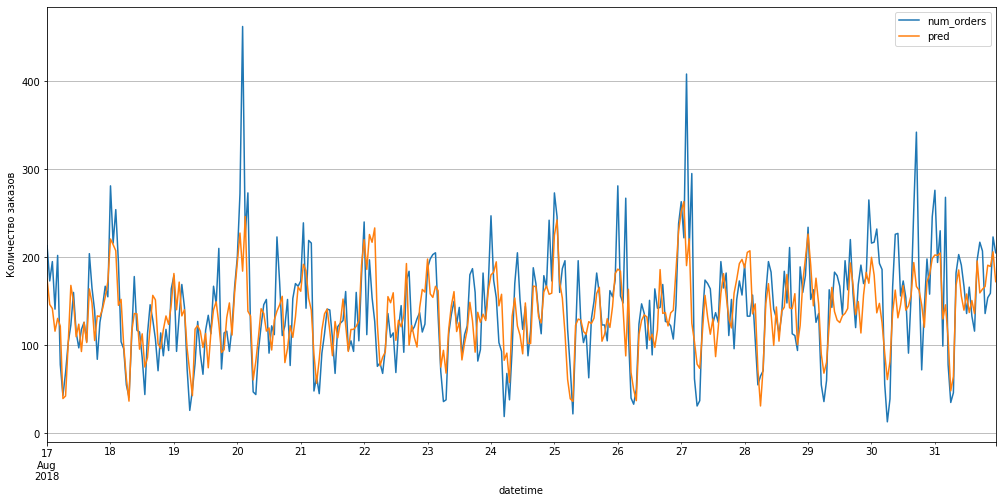

In [33]:
test_check['2018-08-17':].plot(figsize=(17,8), grid=True)
plt.ylabel('Количество заказов');

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">

**Вывод по разделу:**

По графику видно, что модель достаточно точно определяет количество заказов. Но в тестовых данных присутствуют пики, которые модель не смогла предсказать. На их появление могли повлиять различные факторы - от праздников до плохой погоды.

## Общий вывод

* Данные проанализированны. Выявлены тренд возрастающий тренд, стационарная сезонная часть и шум.
* Обучены модели **LinearRegression** и **CatBoostRegressor**, для них подобраны максимальное смещение и шаг скользящего среднего. Обе модели прошли допустимый порог RMSE = 48.
* Лучшей моделью оказалась **CatBoostRegressor** с максимальным смещением = 55 и шагом скользящего среднего = 55, RMSE = 42.7455. Данная модель не определяет выбросы в данных.